In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from collections import Counter

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Mount Drive and Load Data

To create the training dataset, upload the `features_ring.pkl` file or `features_ring` folder, updating the path accordingly.

If this notebook is runned in colab, run this cell


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Change the path accordingly to the execution enviroment (e.g. Colab or locally)

In [2]:
path = '/Users/sebastianosanson/Development/Contacts-Classification/'  # Replace with your path if needed (in case of local execution)

Retrieve the dataset

In [3]:
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label `Unclassified` to None values in the column `Interaction`

In [4]:
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


Mapping the string labels to numericals

In [5]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

y = df['Interaction'].replace(contact_dict)

/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_77603/2894892968.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


Apply a mask in order to get only the needed features to put in the dataset

In [6]:
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

Encoding the categorical features and dropping the `3di_letter` since it represent the same thing of `3di_state`

In [7]:
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

Counting the missing values in order to fill the rows with missing values by putting the mean value of the column

In [8]:
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          17807
s_psi           6736
s_3di_state    37025
t_rsa             75
t_phi           6167
t_psi          21474
t_3di_state    44036
dtype: int64

Total missing values: 133383


Filling the rows with missing values with the mean of the values of that column

In [9]:
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

# Double-check no missing values remain
total_missing = X.isna().sum().sum()
print(f"Total missing values, after refilling: {total_missing}\n")

print(X.head())

Total missing values, after refilling: 0

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
0 -2.322  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0   
1 -1.788  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0   
2 -2.390  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0   
3 -1.088 -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0   
4 -1.551 -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0   

   s_ss8_encoded  t_ss8_encoded  
0              3              7  


This cell it is necessary for eventually engine some features and mandatory for `feature_importance` method

In [10]:
features = ['ss8_encoded','rsa', 'phi', 'psi', 'a1', 'a2', 'a3', 'a4', 'a5', '3di_state']
feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
      't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

## Feature engineering


For each `features` are computed the following math operations:
*   Sum
*   Product
*   Absolute difference
*   Average

In [ ]:
def fe(feature):
  print(f'Engineering feature: {feature}')

  source_feature = 's_' + feature
  target_feature = 't_' + feature

  sum_feature = f'{feature}_sum'
  abs_diff_feature = f'{feature}_abs_diff'
  prod_feature = f'{feature}_prod'
  avg_feature = f'{feature}_avg'

  list_feature_names = [sum_feature, abs_diff_feature, prod_feature, avg_feature]

  X[sum_feature] = X[source_feature] + X[target_feature]
  X[abs_diff_feature] = np.abs(X[source_feature] - X[target_feature])
  X[prod_feature] = X[source_feature] * X[target_feature]
  X[avg_feature] = (X[source_feature] + X[target_feature]) / 2

  print(X.head())

  return list_feature_names

Append the new features created

In [ ]:
for feature in features:
  feature_names.extend(fe(feature))

## Splitting dataset

In [11]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.2,
    random_state=42
)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE 

Computing the inital class distribution

In [ ]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

Applying a sampling strategy in order to oversampling and computing new distribution

In [ ]:
sampling_strategy = {
    0: 675794,  # HBOND
    1: 471719,  # VDW
    2: 24501,  # PIPISTACK
    3: 22650,  # IONIC
    4: 20000,  # PICATION
    5: 10000,  # SSBOND
    6: 10000,  # PIHBOND
    7: 697310   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_train_bal distribution')
for label in sorted(Counter(y_train)):
    print(f"{label}: {Counter(y_train)[label]}")

## XGBoost

### Helper functions

This method compute and plot the feature importance that contributes to the prediction

In [12]:
def feature_importance(model, interaction_type, feature_names):
  # Get feature importances from the model
  importance = model.get_score(importance_type='weight')  

  # Mapping feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sorting the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Plotting the feature importance
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance for ' + str(interaction_type) + ' interaction')
  plt.gca().invert_yaxis() 
  plt.show()

Method that evaluates the models and compute the features importance

In [13]:
import time

def evaluate_model(model, X_test, y_test, class_num, feature_names):
    """
    Evaluate performance of an XGBoost model.

    Parameters:
    -----------
    model_path: str
        Path to the model file
    X_test: numpy array
        Test features
    y_test: numpy array
        Test labels
    class_num: int
        Class number for binary evaluation
    """
    # Binary labels for the current class
    y_test_binary = (y_test == class_num).astype(int)
    dtest = xgb.DMatrix(X_test)

    # Get predictions from the model
    start_time = time.time()
    y_pred_prob = model.predict(dtest)
    inference_time = time.time() - start_time

    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'AUC-ROC',
            'Matthews Correlation',
            'Average Precision',
            'Inference Time (ms)',
        ],
        'Value': [
            accuracy_score(y_test_binary, y_pred_binary),
            balanced_accuracy_score(y_test_binary, y_pred_binary),
            roc_auc_score(y_test_binary, y_pred_prob),
            matthews_corrcoef(y_test_binary, y_pred_binary),
            average_precision_score(y_test_binary, y_pred_prob),
            inference_time * 1000,
        ]
    }

    metrics_df = pd.DataFrame(metrics)

    print(f"\n===== Performance Metrics for Class {class_num} =====")
    print(metrics_df.set_index('Metric').round(4))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Other', f'Class {class_num}'],
                yticklabels=['Other', f'Class {class_num}'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Class {class_num}')
    plt.show()

    print(f"\n===== Feature Importance for Class {class_num} =====")

    # Compute feature importance
    feature_importance(model, class_num, feature_names)

    return metrics_df, y_pred_prob

### Train loop

In [19]:
class_params = {
       0: {  # HBOND
            'max_depth': 20,               # Deeper trees to capture complex rules.
            'learning_rate': 0.08,         # Slightly faster learning.
            'min_child_weight': 2,         # Allow splits even for small groups of samples.
            'subsample': 0.8,              # Use 80% of data per tree.
            'colsample_bytree': 0.8,       # Use 80% of features per tree.
            'gamma': 0.1,                  # Minimum loss reduction to make a split.
            'reg_alpha': 0.1,              # L1 regularization.
            'reg_lambda': 1.0,             # L2 regularization.
        },
        1: {  # VDW 
            'max_depth': 8,
            'learning_rate': 0.05,
            'min_child_weight': 2,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
        },
        2: {  # PIPISTACK
            'max_depth': 6,              # Slightly shallower trees.
            'learning_rate': 0.03,         # Slower learning rate.
            'min_child_weight': 3,       # Require more samples in a leaf to split.
            'subsample': 0.8,             # Use more data per tree to ensure stability.
            'colsample_bytree': 0.7,       # Use fewer features to combat overfitting.
            'gamma': 0.2,
            'reg_alpha': 0.3,
            'reg_lambda': 1.5,
        },
        3: {  # IONIC 
            'max_depth': 6,
            'learning_rate': 0.03,
            'min_child_weight': 3,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'gamma': 0.2,
            'reg_alpha': 0.3,
            'reg_lambda': 1.5,
        },
        4: {  # PICATION
            'max_depth': 4,              # Shallower trees are safer.
            'learning_rate': 0.01,
            'min_child_weight': 5,       # Higher value to prevent learning from noise.
            'subsample': 0.9,
            'colsample_bytree': 0.6,       # Strong feature subsampling.
            'gamma': 0.3,
            'reg_alpha': 0.5,              # Stronger L1 regularization.
            'reg_lambda': 2.0,             # Stronger L2 regularization.
        },
        5: {  # SSBOND 
            'max_depth': 4,
            'learning_rate': 0.01,
            'min_child_weight': 5,
            'subsample': 0.8,
            'colsample_bytree': 0.6,
            'gamma': 0.3,
            'reg_alpha': 0.5,
            'reg_lambda': 2.0,
        },
        6: {  # PIHBOND 
            'max_depth': 4,
            'learning_rate': 0.01,
            'min_child_weight': 5,
            'subsample': 0.9,
            'colsample_bytree': 0.6,
            'gamma': 0.3,
            'reg_alpha': 0.5,
            'reg_lambda': 2.0,
        },
        7: {  # Unclassified
            'max_depth': 20,               # Deeper trees to capture complex rules.
            'learning_rate': 0.08,         # Slightly faster learning.
            'min_child_weight': 2,         # Allow splits even for small groups of samples.
            'subsample': 0.8,              # Use 80% of data per tree.
            'colsample_bytree': 0.8,       # Use 80% of features per tree.
            'gamma': 0.1,                  # Minimum loss reduction to make a split.
            'reg_alpha': 0.1,              # L1 regularization.
            'reg_lambda': 1.0,             # L2 regularization.
        }
    }

Training classifier for Class 0


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:23:50] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-aucpr:0.46362
[10]	validation-aucpr:0.51137
[20]	validation-aucpr:0.51408
[30]	validation-aucpr:0.51292
[40]	validation-aucpr:0.51264
[50]	validation-aucpr:0.51072
[60]	validation-aucpr:0.50768
[70]	validation-aucpr:0.50401

===== Performance Metrics for Class 0 =====
                          Value
Metric                         
Accuracy                 0.6428
Balanced Accuracy        0.6341
AUC-ROC                  0.6949
Matthews Correlation     0.2592
Average Precision        0.5042
Inference Time (ms)   3738.5931


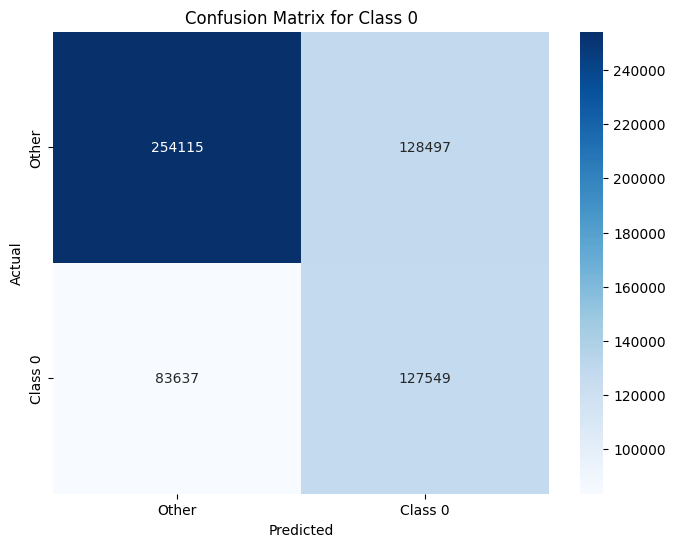


===== Feature Importance for Class 0 =====


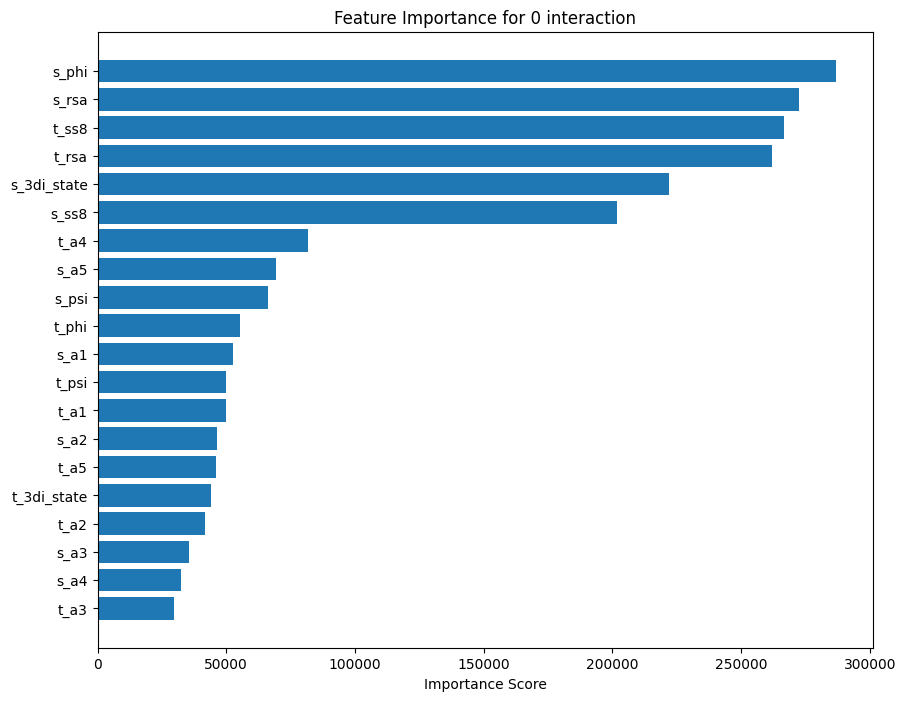

Training classifier for Class 1


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:24:49] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-aucpr:0.27552
[10]	validation-aucpr:0.28244
[20]	validation-aucpr:0.28334
[30]	validation-aucpr:0.28429
[40]	validation-aucpr:0.28503
[50]	validation-aucpr:0.28570
[60]	validation-aucpr:0.28626
[70]	validation-aucpr:0.28668
[80]	validation-aucpr:0.28690
[90]	validation-aucpr:0.28706
[100]	validation-aucpr:0.28720
[110]	validation-aucpr:0.28734
[120]	validation-aucpr:0.28740
[130]	validation-aucpr:0.28755
[140]	validation-aucpr:0.28771
[150]	validation-aucpr:0.28784
[160]	validation-aucpr:0.28796
[170]	validation-aucpr:0.28800
[180]	validation-aucpr:0.28797
[190]	validation-aucpr:0.28796
[200]	validation-aucpr:0.28788
[210]	validation-aucpr:0.28790
[220]	validation-aucpr:0.28782
[223]	validation-aucpr:0.28779

===== Performance Metrics for Class 1 =====
                          Value
Metric                         
Accuracy                 0.5275
Balanced Accuracy        0.5436
AUC-ROC                  0.5625
Matthews Correlation     0.0754
Average Precision        0.288

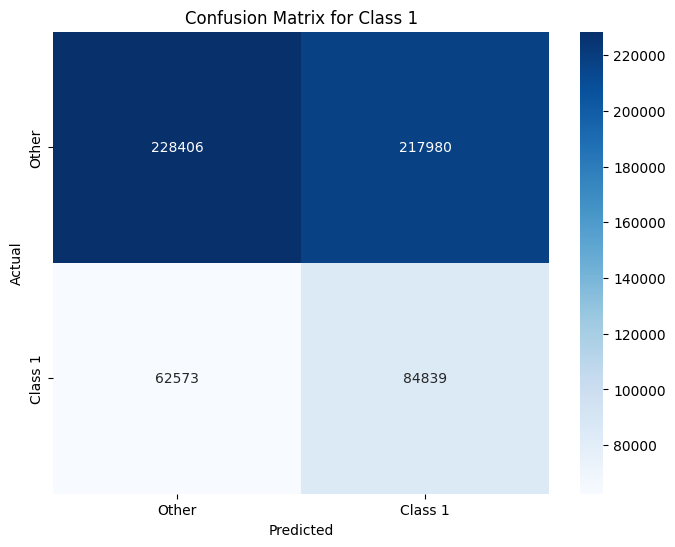


===== Feature Importance for Class 1 =====


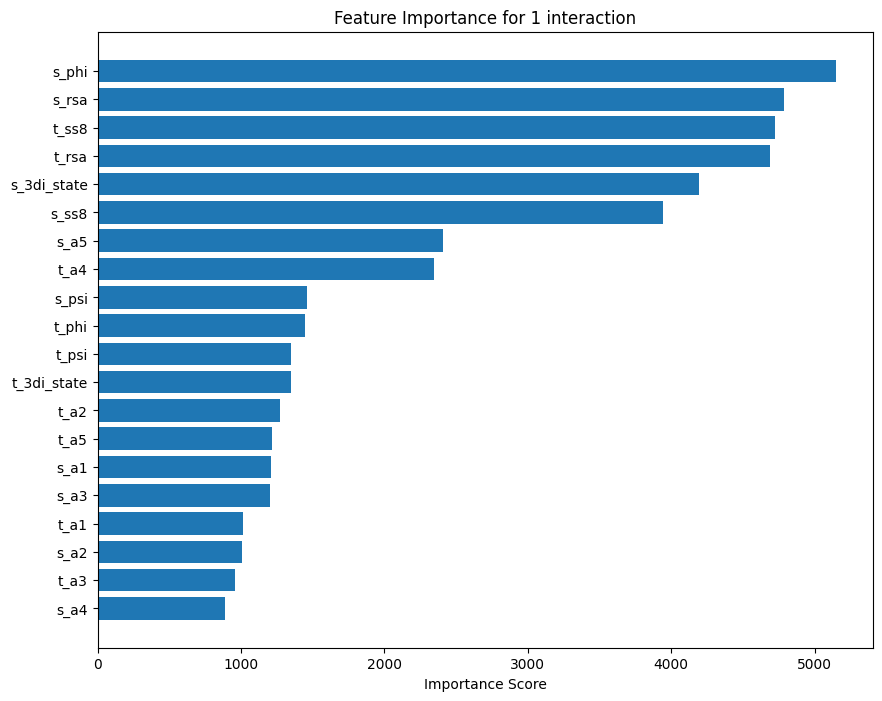

Training classifier for Class 2


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-aucpr:0.12105
[10]	validation-aucpr:0.38277
[20]	validation-aucpr:0.38276
[30]	validation-aucpr:0.38496
[40]	validation-aucpr:0.38495
[50]	validation-aucpr:0.39579
[60]	validation-aucpr:0.40851
[70]	validation-aucpr:0.40868
[80]	validation-aucpr:0.40868
[90]	validation-aucpr:0.40861
[100]	validation-aucpr:0.41168
[110]	validation-aucpr:0.40813
[120]	validation-aucpr:0.40984
[130]	validation-aucpr:0.40968
[140]	validation-aucpr:0.41029
[150]	validation-aucpr:0.41125
[160]	validation-aucpr:0.41825
[170]	validation-aucpr:0.42009
[180]	validation-aucpr:0.42828
[190]	validation-aucpr:0.42869
[200]	validation-aucpr:0.42956
[210]	validation-aucpr:0.43277
[220]	validation-aucpr:0.43396
[230]	validation-aucpr:0.43631
[240]	validation-aucpr:0.43710
[250]	validation-aucpr:0.43844
[260]	validation-aucpr:0.44002
[270]	validation-aucpr:0.44136
[280]	validation-aucpr:0.44240
[290]	validation-aucpr:0.44353
[300]	validation-aucpr:0.44730
[310]	validation-aucpr:0.44721
[320]	validation-au

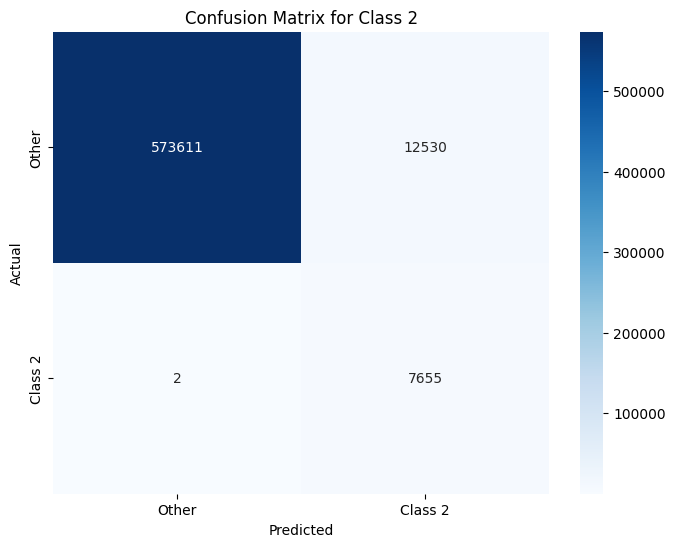


===== Feature Importance for Class 2 =====


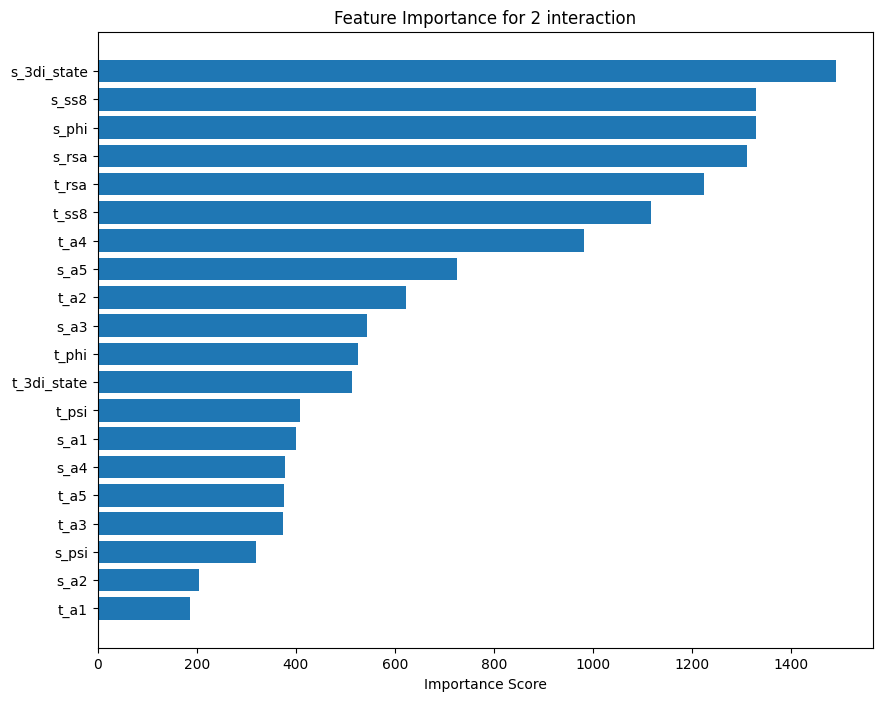

Training classifier for Class 3


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:26:14] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-aucpr:0.07265
[10]	validation-aucpr:0.13232
[20]	validation-aucpr:0.13783
[30]	validation-aucpr:0.17812
[40]	validation-aucpr:0.22330
[50]	validation-aucpr:0.22875
[60]	validation-aucpr:0.22853
[70]	validation-aucpr:0.22825
[80]	validation-aucpr:0.22900
[90]	validation-aucpr:0.22904
[100]	validation-aucpr:0.23006
[110]	validation-aucpr:0.23384
[120]	validation-aucpr:0.23361
[130]	validation-aucpr:0.23412
[140]	validation-aucpr:0.23332
[150]	validation-aucpr:0.23338
[160]	validation-aucpr:0.23415
[170]	validation-aucpr:0.23484
[180]	validation-aucpr:0.23573
[190]	validation-aucpr:0.23766
[200]	validation-aucpr:0.23911
[210]	validation-aucpr:0.23989
[220]	validation-aucpr:0.24054
[230]	validation-aucpr:0.24261
[240]	validation-aucpr:0.24347
[250]	validation-aucpr:0.24427
[260]	validation-aucpr:0.24466
[270]	validation-aucpr:0.24532
[280]	validation-aucpr:0.24582
[290]	validation-aucpr:0.24618
[300]	validation-aucpr:0.24696
[310]	validation-aucpr:0.24703
[320]	validation-au

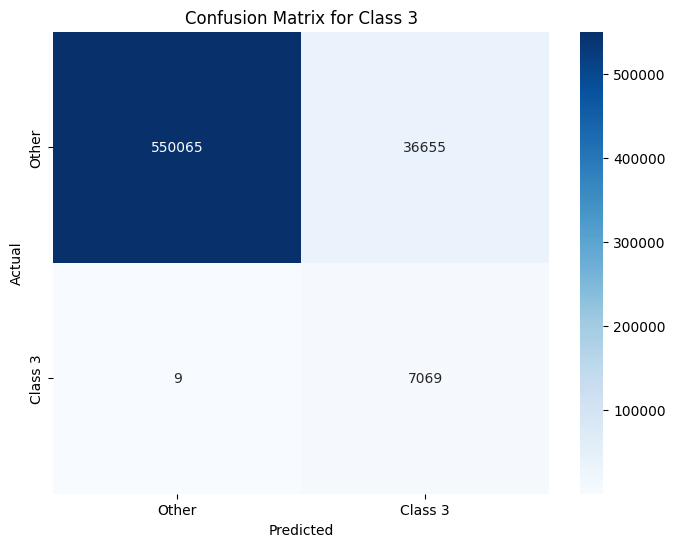


===== Feature Importance for Class 3 =====


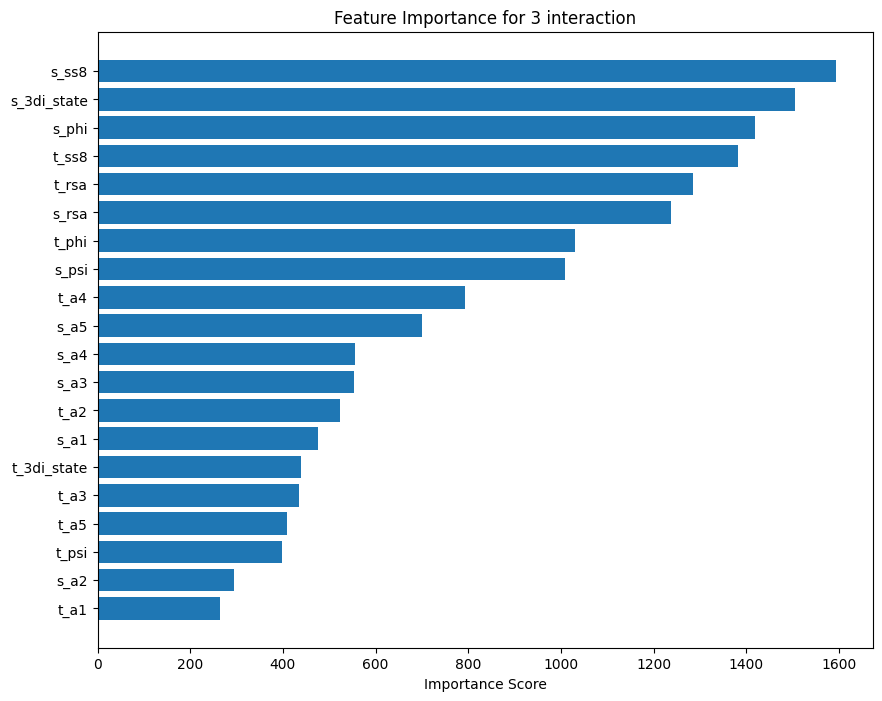

Training classifier for Class 4


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:27:15] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-aucpr:0.01306
[10]	validation-aucpr:0.04951
[20]	validation-aucpr:0.04218
[30]	validation-aucpr:0.06466
[40]	validation-aucpr:0.10275
[50]	validation-aucpr:0.10082
[60]	validation-aucpr:0.10172
[70]	validation-aucpr:0.10631
[80]	validation-aucpr:0.10877
[90]	validation-aucpr:0.10926
[100]	validation-aucpr:0.10891
[110]	validation-aucpr:0.10841
[120]	validation-aucpr:0.10951
[130]	validation-aucpr:0.11249
[140]	validation-aucpr:0.12037
[150]	validation-aucpr:0.11986
[160]	validation-aucpr:0.11991
[170]	validation-aucpr:0.11995
[180]	validation-aucpr:0.11996
[190]	validation-aucpr:0.11996
[196]	validation-aucpr:0.11986

===== Performance Metrics for Class 4 =====
                         Value
Metric                        
Accuracy                0.9157
Balanced Accuracy       0.9577
AUC-ROC                 0.9883
Matthews Correlation    0.1771
Average Precision       0.1195
Inference Time (ms)   422.0538


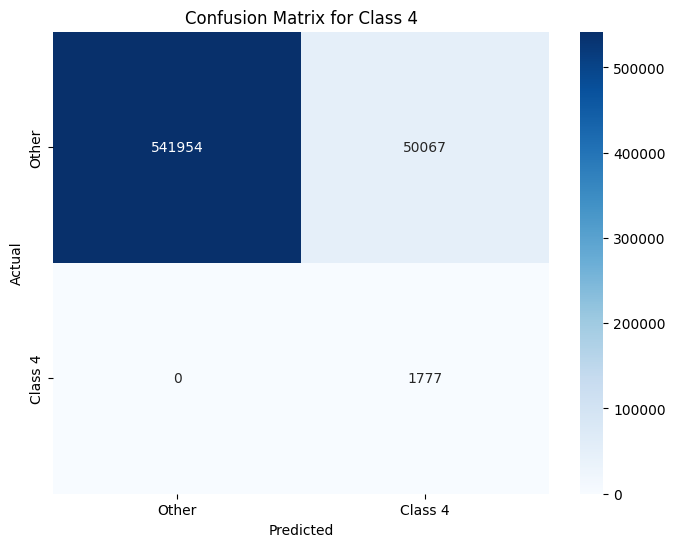


===== Feature Importance for Class 4 =====


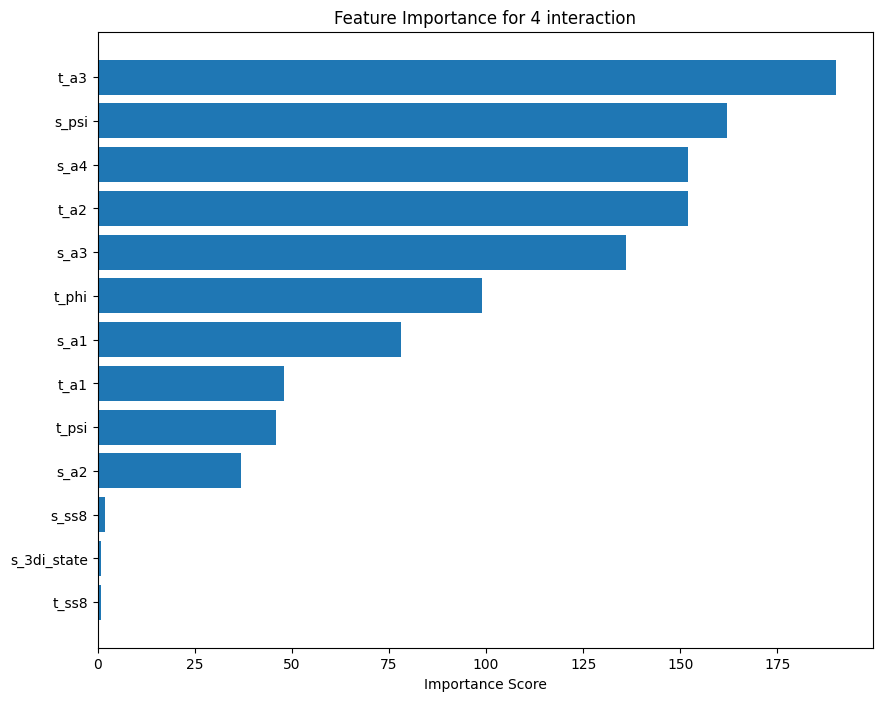

Training classifier for Class 5


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:27:31] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-aucpr:0.38799
[10]	validation-aucpr:0.38799
[20]	validation-aucpr:0.38799
[30]	validation-aucpr:0.38799
[40]	validation-aucpr:0.38799
[50]	validation-aucpr:0.38799

===== Performance Metrics for Class 5 =====
                        Value
Metric                       
Accuracy               0.9988
Balanced Accuracy      0.9994
AUC-ROC                0.9994
Matthews Correlation   0.6098
Average Precision      0.3723
Inference Time (ms)   38.8482


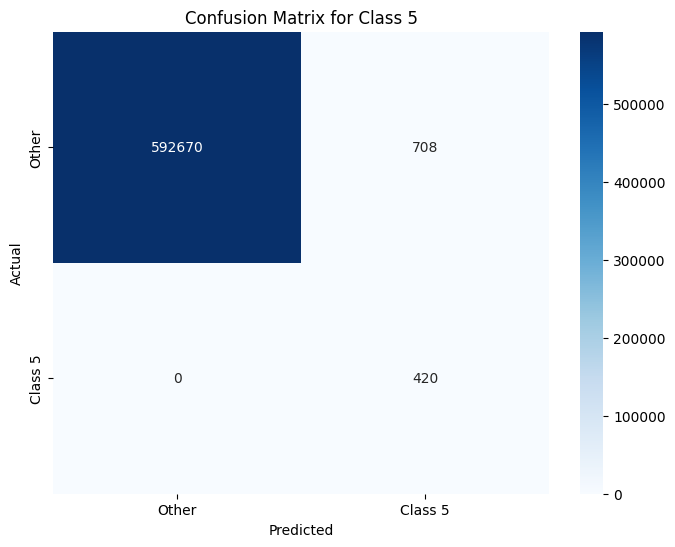


===== Feature Importance for Class 5 =====


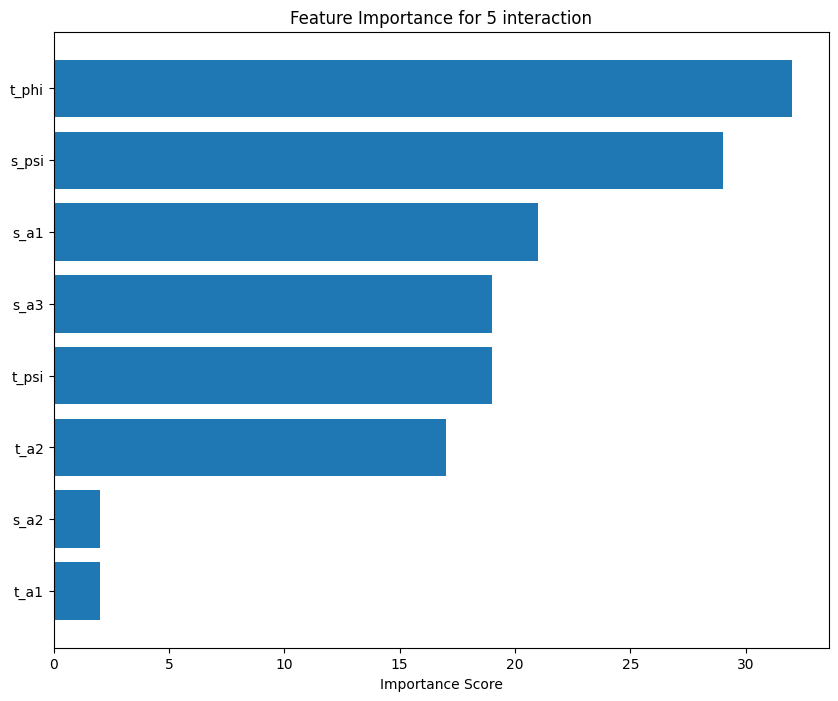

Training classifier for Class 6


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:27:35] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-aucpr:0.00253
[10]	validation-aucpr:0.00550
[20]	validation-aucpr:0.00563
[30]	validation-aucpr:0.00547
[40]	validation-aucpr:0.00538
[50]	validation-aucpr:0.00679
[60]	validation-aucpr:0.00750
[70]	validation-aucpr:0.00766
[80]	validation-aucpr:0.00802
[90]	validation-aucpr:0.00834
[100]	validation-aucpr:0.00836
[110]	validation-aucpr:0.00892
[120]	validation-aucpr:0.00911
[130]	validation-aucpr:0.00919
[140]	validation-aucpr:0.00930
[150]	validation-aucpr:0.00935
[160]	validation-aucpr:0.00966
[170]	validation-aucpr:0.00968
[180]	validation-aucpr:0.00961
[190]	validation-aucpr:0.00965
[200]	validation-aucpr:0.00964
[210]	validation-aucpr:0.00965
[220]	validation-aucpr:0.00973
[230]	validation-aucpr:0.00965
[240]	validation-aucpr:0.00970
[250]	validation-aucpr:0.00970
[260]	validation-aucpr:0.00975
[270]	validation-aucpr:0.00998
[280]	validation-aucpr:0.01006
[290]	validation-aucpr:0.01034
[300]	validation-aucpr:0.01025
[310]	validation-aucpr:0.01030
[320]	validation-au

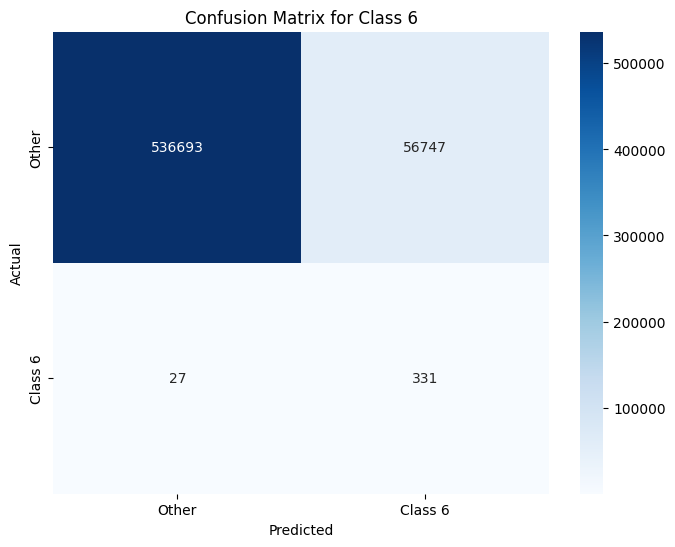


===== Feature Importance for Class 6 =====


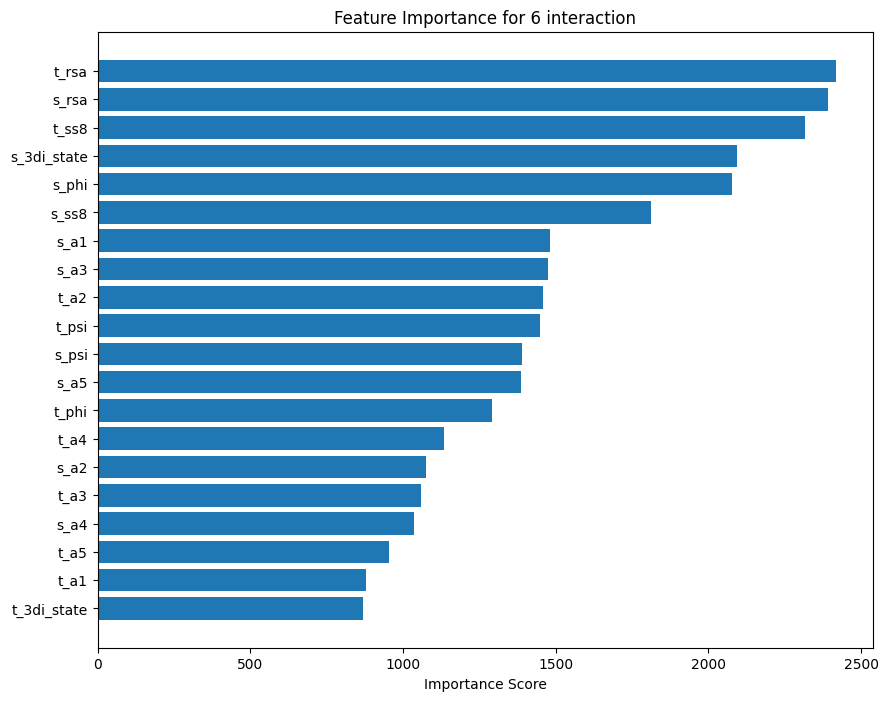

Training classifier for Class 7


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:32:16] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-aucpr:0.53166
[10]	validation-aucpr:0.64093
[20]	validation-aucpr:0.66070
[30]	validation-aucpr:0.67147
[40]	validation-aucpr:0.67737
[50]	validation-aucpr:0.68293
[60]	validation-aucpr:0.68587
[70]	validation-aucpr:0.68865
[80]	validation-aucpr:0.69068
[90]	validation-aucpr:0.69285
[100]	validation-aucpr:0.69434
[110]	validation-aucpr:0.69576
[120]	validation-aucpr:0.69740
[130]	validation-aucpr:0.69908
[140]	validation-aucpr:0.70002
[150]	validation-aucpr:0.70096
[160]	validation-aucpr:0.70227
[170]	validation-aucpr:0.70300
[180]	validation-aucpr:0.70415
[190]	validation-aucpr:0.70505
[200]	validation-aucpr:0.70585
[210]	validation-aucpr:0.70672
[220]	validation-aucpr:0.70712
[230]	validation-aucpr:0.70766
[240]	validation-aucpr:0.70833
[250]	validation-aucpr:0.70879
[260]	validation-aucpr:0.70944
[270]	validation-aucpr:0.70998
[280]	validation-aucpr:0.71051
[290]	validation-aucpr:0.71110
[300]	validation-aucpr:0.71150
[310]	validation-aucpr:0.71184
[320]	validation-au

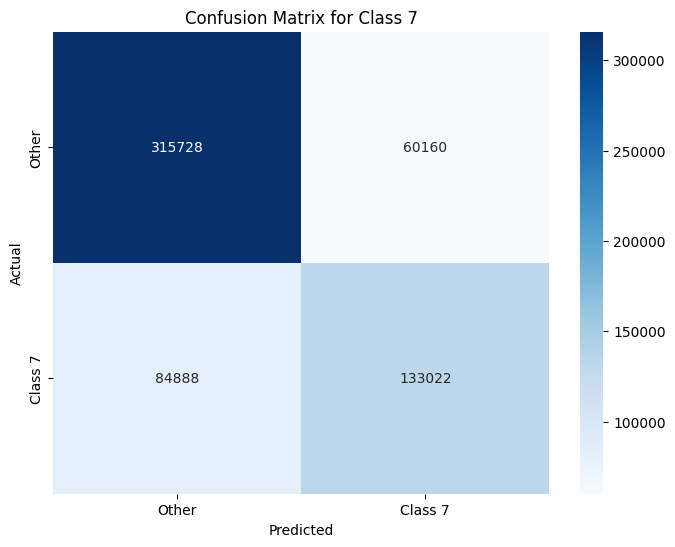


===== Feature Importance for Class 7 =====


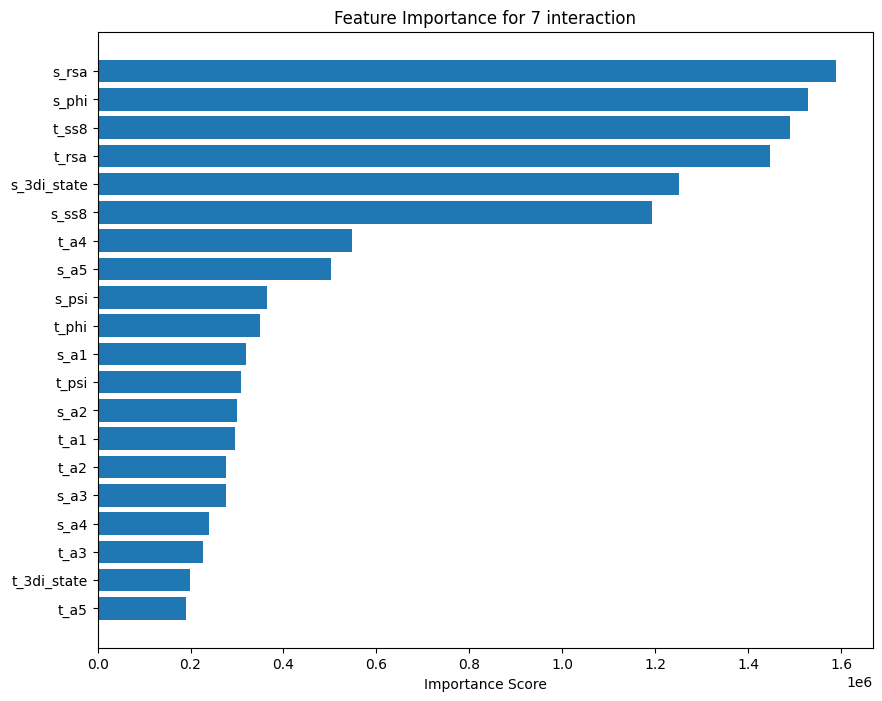

In [20]:
# For each class, train a binary classifier
for num_class in range(len(np.unique(y_train))):
    print(f'Training classifier for Class {num_class}')

    # Mapping labels: 1 for current class, 0 for all other classes
    y_train_binary = (y_train == num_class).astype(int)
    y_val_binary = (y_val == num_class).astype(int)

    dtrain = xgb.DMatrix(X_train, label=y_train_binary)
    dval = xgb.DMatrix(X_val, label=y_val_binary)

    # Count num negative/positive examples for this class
    neg_count = np.sum(y_train_binary == 0)
    pos_count = np.sum(y_train_binary == 1)
    scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

    # Get base params
    params = {
        'device': 'cuda',
        'seed': 42,
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'max_delta_step': 3
    }

    # Update with class-specific params
    params.update(class_params[num_class])
    params['scale_pos_weight'] = scale_pos_weight
        
    model = xgb.train(
        params = params,
        dtrain=dtrain,
        num_boost_round=2500,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=10
    )

    # Save model
    os.makedirs(os.path.join(path, 'models/bin_models'), exist_ok=True)
    model.save_model(os.path.join(path, f'models/bin_models/xgboost_model_class_{num_class}.json'))

    # Evaluate the model
    evaluate_model(model, X_test, y_test, num_class, feature_names)

## Combines models

Now all the binary classifier will be unified in order to obtain a multiclassifier

In [21]:
from collections import defaultdict

class UnifiedXGBoostEnsemble:
    """Unified model that combines multiple binary XGBoost models"""

    def __init__(self, models_dir):
        """Load all models from the directory"""
        self.models = []
        self.models_dir = models_dir

        # Load models in order by class number
        for class_num in range(8):  # Assuming 8 classes
            model_path = os.path.join(models_dir, f"xgboost_model_class_{class_num}.json")
            if os.path.exists(model_path):
                model = xgb.Booster()
                model.load_model(model_path)
                self.models.append(model)

        self.n_classes = len(self.models)
        print(f"Successfully loaded {self.n_classes} models from {models_dir}")

    def predict_proba(self, X):
        """Get probability predictions from all models"""
        dtest = xgb.DMatrix(X)
        probas = []

        for model in self.models:
            # Get class probability from each model
            proba = model.predict(dtest)
            probas.append(proba)

        return np.column_stack(probas)

    def predict(self, X):
        """Make final predictions using max probability"""
        probas = self.predict_proba(X)
        # probas_normalized = probas / np.sum(probas, axis=1, keepdims=True)

        return np.argmax(probas, axis=1)

def aggregate_feature_importance(models):
    """Aggregate feature importance scores across multiple models"""
    all_importances = defaultdict(list)
    
    # Collect importances from all models
    for model in models:
        importances = model.get_score(importance_type='weight')
        for feature, score in importances.items():
            all_importances[feature].append(score)
    
    # Compute mean importance for each feature
    mean_importances = {}
    for feature, scores in all_importances.items():
        mean_importances[feature] = sum(scores) / len(scores)
    
    return mean_importances

def evaluate_unified_ensemble(model, X_test, y_test, class_names=None):
    """
    Evaluate the unified ensemble with comprehensive metrics
    """
    if class_names is None:
        class_names = [f"Class {i}" for i in range(model.n_classes)]

    print("\n===== Evaluating Unified Ensemble (Max Probability) =====\n")

    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    probas = model.predict_proba(X_test)

    # Calculate overall metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'Matthews Correlation Coefficient'
        ],
        'Value': [
            accuracy_score(y_test, y_pred),
            balanced_accuracy_score(y_test, y_pred),
            matthews_corrcoef(y_test, y_pred)
        ]
    }

    # Print overall metrics
    metrics_df = pd.DataFrame(metrics)
    print("Overall Metrics:")
    print(metrics_df.set_index('Metric').round(4))

    # Calculate per-class metrics
    roc_aucs = []
    avg_precisions = []

    print("\nPer-Class Metrics:")
    for i in range(model.n_classes):
        # Binary encoding for this class
        y_true_bin = (y_test == i).astype(int)
        y_score = probas[:, i]

        # ROC AUC
        roc_auc = roc_auc_score(y_true_bin, y_score)
        roc_aucs.append(roc_auc)

        # Average Precision
        avg_prec = average_precision_score(y_true_bin, y_score)
        avg_precisions.append(avg_prec)

        print(f"{class_names[i]}: ROC AUC = {roc_auc:.4f}, Avg Precision = {avg_prec:.4f}")

    print(f"\nMacro-Average ROC AUC: {np.mean(roc_aucs):.4f}")
    print(f"Macro-Average Precision: {np.mean(avg_precisions):.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Unified Ensemble')
    plt.show()

    # Compute feature importance aggregation for the unified ensemble
    feature_importance = aggregate_feature_importance(model.models)
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*feature_importance)     
    plt.figure(figsize=(10, 8))
    plt.barh(features, scores)
    plt.xlabel('Importance Score')
    plt.title('Feature Importance - Unified Ensemble')
    plt.gca().invert_yaxis()  
    plt.show()

    return {
        'accuracy': metrics['Value'][0],
        'balanced_accuracy': metrics['Value'][1],
        'matthews_corr': metrics['Value'][2],
        'roc_auc_per_class': roc_aucs,
        'avg_precision_per_class': avg_precisions,
        'predictions': y_pred,
        'probabilities': probas
    }

Unify the models and evaluation

Successfully loaded 8 models from models/bin_models

===== Evaluating Unified Ensemble (Max Probability) =====

Overall Metrics:
                                   Value
Metric                                  
Accuracy                          0.4575
Balanced Accuracy                 0.6508
Matthews Correlation Coefficient  0.2543

Per-Class Metrics:
HBOND: ROC AUC = 0.6949, Avg Precision = 0.5042
VDW: ROC AUC = 0.5625, Avg Precision = 0.2888
PIPISTACK: ROC AUC = 0.9911, Avg Precision = 0.4444
IONIC: ROC AUC = 0.9783, Avg Precision = 0.2440
PICATION: ROC AUC = 0.9883, Avg Precision = 0.1195
SSBOND: ROC AUC = 0.9994, Avg Precision = 0.3723
PIHBOND: ROC AUC = 0.9662, Avg Precision = 0.0173
Unclassified: ROC AUC = 0.8298, Avg Precision = 0.7174

Macro-Average ROC AUC: 0.8763
Macro-Average Precision: 0.3385


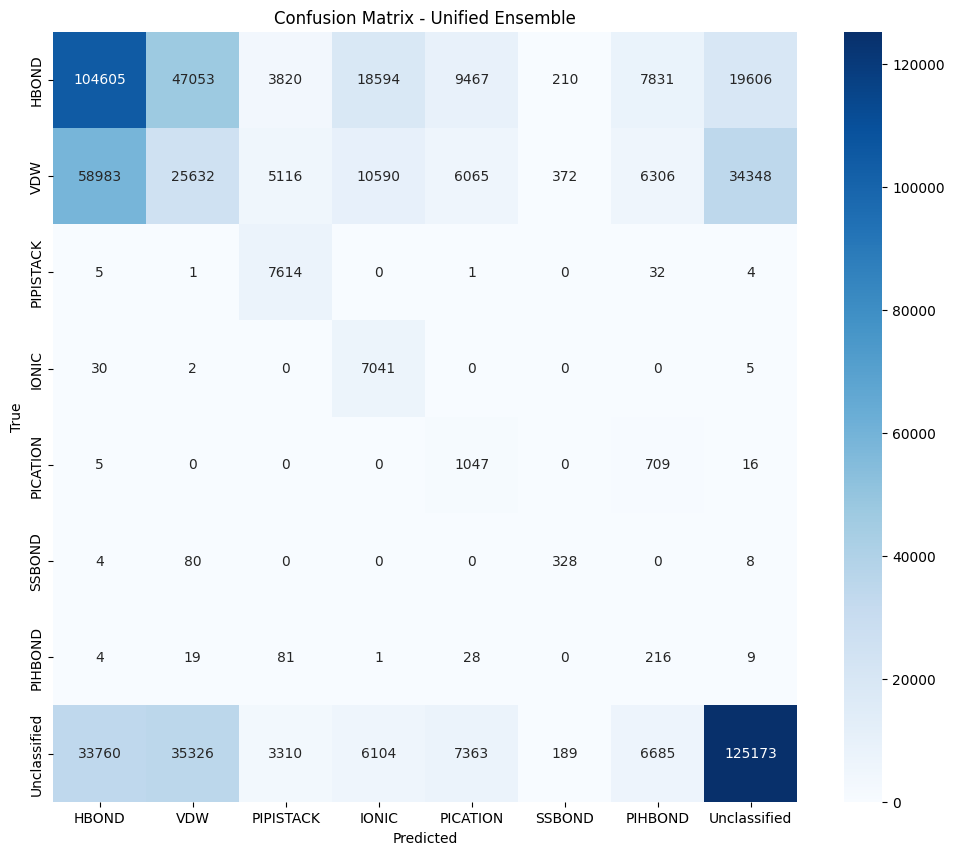

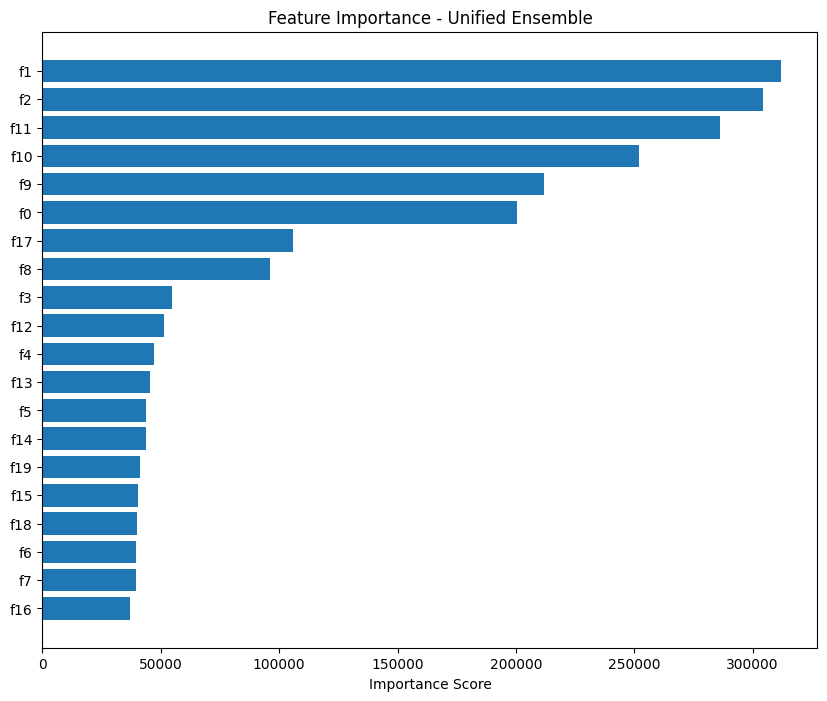

In [22]:
models_dir = 'models/bin_models'
class_names = ["HBOND", "VDW", "PIPISTACK", "IONIC", "PICATION", "SSBOND", "PIHBOND", "Unclassified"]

unified_model = UnifiedXGBoostEnsemble(models_dir)
results = evaluate_unified_ensemble(unified_model, X_test, y_test, class_names)

## Features selection

For unified model

In [ ]:
from collections import defaultdict

def feature_selection_for_unified_model(model_dir, X_train, y_train, X_test, y_test, feature_names, threshold_method='mean'):
    """
    Perform feature selection for UnifiedXGBoostEnsemble by aggregating feature importance
    from all binary models.
    
    Parameters:
    -----------
    model_dir: str
        Directory containing the binary model files
    X_train, y_train: numpy arrays
        Training data
    X_test, y_test: numpy arrays
        Test data
    feature_names: list
        Names of all features
    threshold_method: str
        Method to determine threshold ('mean', 'median', or float value)
    """
    # Load all binary models
    models = []
    for class_num in range(8):  # Assuming 8 classes
        model_path = os.path.join(model_dir, f"xgboost_model_class_{class_num}.json")
        if os.path.exists(model_path):
            model = xgb.Booster()
            model.load_model(model_path)
            models.append(model)
    
    print(f"Loaded {len(models)} binary models from {model_dir}")
    
    # Aggregate feature importance across all models
    aggregated_importance = defaultdict(float)
    
    for model in models:
        importance = model.get_score(importance_type='weight')
        for feature, score in importance.items():
            feature_idx = int(feature.replace('f', ''))
            aggregated_importance[feature_idx] += score
    
    # Convert to list of (feature_idx, importance) tuples
    importance_list = [(idx, score) for idx, score in aggregated_importance.items()]
    importance_list.sort(key=lambda x: x[1], reverse=True)
    
    # Calculate threshold 
    importance_values = np.array([score for _, score in importance_list])
    if threshold_method == 'mean':
        threshold = np.mean(importance_values)
    elif threshold_method == 'median':
        threshold = np.median(importance_values)
    elif isinstance(threshold_method, float):
        threshold = threshold_method
    else:
        threshold = np.mean(importance_values)  
    
    print(f"Feature importance threshold: {threshold:.4f}")
    
    # Select features above threshold
    selected_indices = [idx for idx, score in importance_list if score > threshold]
    
    # If no features selected, use top 10
    if not selected_indices:
        print("No features above threshold, using top 10 instead")
        selected_indices = [idx for idx, _ in importance_list[:10]]
    
    # Ensure indices are within valid range
    selected_indices = [idx for idx in selected_indices if idx < X_train.shape[1]]
    
    print(f"Selected {len(selected_indices)} features out of {X_train.shape[1]}")
    
    # Display selected feature names if available
    if feature_names:
        selected_names = [feature_names[idx] for idx in selected_indices]
        print("Selected features:")
        for idx, name in zip(selected_indices, selected_names):
            print(f"  - {name} (index: {idx})")
    
    # Plot aggregate feature importance
    plt.figure(figsize=(12, 8))
    if feature_names:
        top_features = [(feature_names[idx], score) for idx, score in importance_list[:20]]
        features, scores = zip(*top_features)
    else:
        top_features = importance_list[:20]
        features = [f"Feature {idx}" for idx, _ in top_features]
        scores = [score for _, score in top_features]
    
    plt.barh(features, scores)
    plt.xlabel('Aggregated Importance Score')
    plt.title('Top Features by Aggregated Importance')
    plt.gca().invert_yaxis()  
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Filter data to only include selected features
    X_train_selected = X_train[:, selected_indices]
    X_val_selected = X_val[:, selected_indices]
    
    new_models = []
    
    # Train new binary models with selected features
    for class_num in range(8):
        print(f"Training pruned model for Class {class_num} with selected features")
        
        # Create binary labels
        y_train_binary = (y_train == class_num).astype(int)
        y_val_binary = (y_val == class_num).astype(int)
        
        dtrain = xgb.DMatrix(X_train_selected, label=y_train_binary)
        dval = xgb.DMatrix(X_val_selected, label=y_val_binary)
        
        # Train pruned model
        pruned_model = xgb.train(
        params = {
            'device': 'cuda',
            'seed': 42,
            'objective': 'binary:logistic',
            'eval_metric': ['auc', 'error', 'aucpr'],
            'max_depth': 15,
            'learning_rate': 0.02,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'gamma': 0.2,
            'reg_alpha': 0.3,
            'reg_lambda': 1.5,
            'min_child_weight': 3
        },
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=50
    )
        
        new_models.append(pruned_model)
        
        # Save pruned model
        os.makedirs(os.path.join('models', 'unified_pruned'), exist_ok=True)
        pruned_model.save_model(os.path.join('models', 'unified_pruned', f'xgboost_model_class_{class_num}.json'))
    
    # Create and evaluate the pruned unified model
    class PrunedUnifiedXGBoostEnsemble:
        def __init__(self, models, selected_indices):
            self.models = models
            self.selected_indices = selected_indices
            self.n_classes = len(models)
            
        def predict_proba(self, X):
            # Filter features first
            X_selected = X[:, self.selected_indices]
            dtest = xgb.DMatrix(X_selected)
            probas = []
            
            for model in self.models:
                proba = model.predict(dtest)
                probas.append(proba)
            
            return np.column_stack(probas)
            
        def predict(self, X):
            probas = self.predict_proba(X)
            return np.argmax(probas, axis=1)
    
    # Create the pruned unified model
    pruned_unified_model = PrunedUnifiedXGBoostEnsemble(new_models, selected_indices)
    
    print("\nEvaluating pruned unified model...")
    
    try:
        class_names = ["HBOND", "VDW", "PIPISTACK", "IONIC", "PICATION", "SSBOND", "PIHBOND", "Unclassified"]
        _ = evaluate_unified_ensemble(pruned_unified_model, X_test, y_test, class_names)
    except:
        y_pred = pruned_unified_model.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        print(f"Pruned model accuracy: {accuracy:.4f}")
    
    return pruned_unified_model, selected_indices

In [ ]:
pruned_model, selected_features = feature_selection_for_unified_model(
    'models/bin_models', 
    X_train, y_train, 
    X_test, y_test, 
    feature_names
)